In [1]:
# Run *in vitro* growth simulations, as described in Monk et al. 10.1073/pnas.1307797110

import cobra
import os
import libsbml
import pandas as pd
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
import itertools


## For specific growth conditions simulations:
### For anaerobic condtions:
EX_o2_e (0, 1000)
### For carbon source profilling:
EX_glc__D_e (0, 1000)
### For nitrogen source profilling:
EX_nh4_e (0, 1000)
### For phosphorous source profilling:
EX_pi_e (0, 1000)
### For sulfur source profilling:
EX_so4_e (0, 1000)

In [98]:
def defineM9():
    """
    Reads in M9 conditions from file, returns dataframe of M9 conditons, reactions as index
    """
    
    m9_cond_file = "/Users/annasintsova/git_repos/HUTI-RNAseq/"\
                "analysis/fba/2018-03-21-clinical-strain-metabolism/data/"\
                "M9_conditions.csv"
    m9 = pd.read_csv(m9_cond_file, index_col=0)
    m9_reactions = list(m9.index)
    m9_reactions[19] = "EX_glc__D_e"
    m9.index = m9_reactions
    return m9

In [99]:
def growthSimulation(models, conditions, out_dir):
    """
    Return dataframe with all models growth under all conditions
    For each model run FBA with all specified conditions: seperate function
    
    """
    all_growth = []
    model_index = []
    for model in models:
        print("Working on: {}".format(model.id))
        growth = doesItGrow(model, conditions)
        all_growth.append(growth)
        model_index.append(model.id)
    print("Putting data together into a dataframe")
    growth_simulation = pd.DataFrame(all_growth)
    growth_simulation.index = model_index
    
    print("Removing 'no growth' conditions")
    growing = growth_simulation.loc[:,(growth_simulation.sum(axis=0) != 0)]
    
    growing.to_csv(os.path.join(out_dir, 
                    "{}_growth_simulations.csv".format(dt.datetime.today().strftime("%Y-%m-%d"))))
    print("Done")
    return growing
    

In [100]:
def growthSimulation2(models, out_dir):
    """
    Return dataframe with all models growth under all conditions
    For each model run FBA with all specified conditions: seperate function
    
    """
    all_growth = []
    model_index = []
    for model in models:
        conditions = setConditions(model, getReactionIds(model))
        growth = doesItGrow(model, conditions)
        all_growth.append(growth)
        model_index.append(model.id)
    growth_simulation = pd.DataFrame(all_growth)
    growth_simulation.index = model_index
    growth_simulation.to_csv(os.path.join(out_dir, 
                    "{}_growth_simulations.csv".format(dt.datetime.today().strftime("%Y-%m-%d"))))
    return growth_simulation

In [101]:
def doesItGrow(model, conditions):
    """
    Return dictionary of {condition:(no)growth} for a model
    
    1. Set model to M9 conditions
    2. Go through list of conditions run fba, collect data on growth
    
        simulation_condition: list of tuples: [(element (C, N, P, S), reaction.id, oxygen (True/False))
        
    3. restore original settings
    
    """
    # 1
    m9_settings = defineM9()
    print("Setting M9 conditions")
    model = setToM9(model, m9_settings)
    
  
    growth = {}
    for condition in conditions:
        
        air_status = "AERO" if condition[2] else "ANAERO"
        cname = "{}_{}_{}".format(condition[0], air_status, condition[1])
        print("Testing: {}".format(cname))
        
        #2
        if condition[0] == "C":
            element = model.reactions.EX_glc__D_e
        elif condition[0] == "N":
            element = model.reactions.EX_nh4_e
        elif condition[0] == "P":
            element = model.reactions.EX_pi_e
        elif condition[0] == "S":
            element = model.reactions.EX_so4_e
        else:
            print("wrong condition format")
            
        original_element_lb = element.lower_bound
        original_element_up = element.uppper_bound
        element.lower_bound = 0
        element.upper_bound = 1000
        
        r = model.reactions.get_by_id(condition[1])
        original_lower_bound = r.lower_bound
        r.lower_bound = -1000
            
        
        ox = model.reactions.EX_o2_e
        if not condition[2]:
            ox.lower_bound = 0
        
        obj = round(model.optimize().objective_value,4)
        growth[cname] = obj if obj > 0 else 0
        
        #3 
        element.lower_bound = original_element_lb
        element.upper_bound = original_element_up
        r.lower_bound = original_lower_bound
        ox.lower_bound = -1000.0
            
    return growth
    

In [102]:
def setToM9(model, m9_settings):
    
    m9_reactions = list(m9_settings.index)
    original_settings = {k:[model.reactions.get_by_id(k).name, model.reactions.get_by_id(k).lower_bound, 
                            model.reactions.get_by_id(k).upper_bound] for k in m9_reactions}
    
    #print(original_settings)
    
    for rx in original_settings.keys():
        new_lower_bound = m9_settings.loc[rx]["lower_bound"]
        new_upper_bound = m9_settings.loc[rx]["upper_bound"]
        model.reactions.get_by_id(rx).lower_bound = new_lower_bound
        model.reactions.get_by_id(rx).uppper_bound = new_upper_bound
    new_settings = {k:[model.reactions.get_by_id(k).name, model.reactions.get_by_id(k).lower_bound, 
                       model.reactions.get_by_id(k).upper_bound] for k in m9_reactions}
    #print(new_settings)
    return model

In [6]:
# Using one model for now

model_path = "/Users/annasintsova/git_repos/"\
        "HUTI-RNAseq/analysis/fba/2017-12-16-model-2/data/"\
        "HM54_homologues/HM54_model/HM54_iML1515.xml"
model = cobra.io.read_sbml_model(model_path)

In [27]:
def getReactionIds(model):
    conditions = []
    r_ids = {}
    conditions_with_growth_file = "/Users/annasintsova/git_repos/HUTI-RNAseq/"\
                    "analysis/fba/2018-03-21-clinical-strain-metabolism/data/"\
                    "conditionsWithGrowthMonk.csv"
    growth_cond = pd.read_csv(conditions_with_growth_file, index_col=0)

    for i in growth_cond.index:
        rnames = set([c.split("_")[2].strip() for c in growth_cond.index])
        for rx in model.reactions:
            if rx.name in rnames:
                r_ids[rx.name] = rx.id
                rnames.remove(rx.name)
    
    
    rx_info_file = "/Users/annasintsova/git_repos/HUTI-RNAseq/"\
                    "analysis/fba/2018-03-21-clinical-strain-metabolism/data/"\
                    "reactionInformationMonk.csv"
    rx_info = pd.read_csv(rx_info_file, index_col=1)
    
    df = rx_info.loc[rnames]
    for n, r in zip(df.index, df["Reaction Abbreviation"]):
    
        try:
            if model.reactions.get_by_id(r):
                r_ids[n] = r
                rnames.remove(n)           
        except:
            pass
    #Not ideal, but I don't think this matters a huge deal, got 207 out of 221
    return r_ids



In [35]:
def setConditions(model, reaction_ids):
    conditions_with_growth_file = "/Users/annasintsova/git_repos/HUTI-RNAseq/"\
                    "analysis/fba/2018-03-21-clinical-strain-metabolism/data/"\
                    "conditionsWithGrowthMonk.csv"
            
    growth_cond = pd.read_csv(conditions_with_growth_file, index_col=0)
    
    conditions = []
    for c in growth_cond.index:
        if c.split("_")[2] in reaction_ids.keys():
            element = c.split("_")[0]
            ox = True if c.split("_")[1] == "AERO" else False
            reaction = reaction_ids[c.split("_")[2]]
            conditions.append((element, reaction, ox))
    return conditions


In [58]:
def allCond(model):
    
    elements = ["C", "N", "P", "S"]
    reactions = [rx.id for rx in model.reactions if "EX_" in rx.id]
    ox = [True, False]
    conditions = list(itertools.product(elements, reactions, ox))
    return conditions
    


[('C', 'Ex__glc__D_E', True),
 ('C', 'Ex__glc__D_E', False),
 ('N', 'Ex__glc__D_E', True),
 ('N', 'Ex__glc__D_E', False),
 ('P', 'Ex__glc__D_E', True),
 ('P', 'Ex__glc__D_E', False),
 ('S', 'Ex__glc__D_E', True),
 ('S', 'Ex__glc__D_E', False)]

In [103]:
#Testing
models = [model]
conditions = [("C", "EX_glc__D_e", True), ("C", "EX_glc__D_e", False)]
#conditions = setConditions(model, getReactionIds(model))
out_dir = "/Users/annasintsova/git_repos/HUTI-RNAseq/"\
            "analysis/fba/2018-03-21-clinical-strain-metabolism/data/"
                
df = growthSimulation(models, conditions, out_dir)


Working on: HM54_iML1515
Setting M9 conditions
Testing: C_AERO_EX_glc__D_e
Testing: C_ANAERO_EX_glc__D_e
Putting data together into a dataframe
Removing 'no growth' conditions
Done


,C_AERO_EX_glc__D_e,C_ANAERO_EX_glc__D_e
HM54_iML1515,11.8789,11.0295


In [106]:
# Run Simulation
model_path = "/Users/annasintsova/git_repos/HUTI-RNAseq/analysis/fba/2018-03-21-clinical-strain-metabolism/data/models"
os.listdir(model_path)
models = [cobra.io.read_sbml_model(os.path.join(model_path, mp)) for mp in os.listdir(model_path)]

out_dir = "/Users/annasintsova/git_repos/HUTI-RNAseq/"\
            "analysis/fba/2018-03-21-clinical-strain-metabolism/data/"
    
df = growthSimulation2(models, out_dir)

Setting M9 conditions
Testing: C_AERO_EX_glyc__R_e
Testing: C_AERO_EX_4abut_e
Testing: C_AERO_EX_acald_e
Testing: C_AERO_EX_adn_e
Testing: C_AERO_EX_amp_e
Testing: C_AERO_EX_cmp_e
Testing: C_AERO_EX_cytd_e
Testing: C_AERO_EX_ala__D_e
Testing: C_AERO_EX_damp_e
Testing: C_AERO_EX_dcmp_e
Testing: C_AERO_EX_dca_e
Testing: C_AERO_EX_dad_2_e
Testing: C_AERO_EX_dcyt_e
Testing: C_AERO_EX_dgsn_e
Testing: C_AERO_EX_din_e
Testing: C_AERO_EX_duri_e
Testing: C_AERO_EX_f6p_e
Testing: C_AERO_EX_fru_e
Testing: C_AERO_EX_glcn_e
Testing: C_AERO_EX_gam6p_e
Testing: C_AERO_EX_g6p_e
Testing: C_AERO_EX_glc__D_e
Testing: C_AERO_EX_dgmp_e
Testing: C_AERO_EX_dha_e
Testing: C_AERO_EX_dimp_e
Testing: C_AERO_EX_lac__D_e
Testing: C_AERO_EX_man6p_e
Testing: C_AERO_EX_ddca_e
Testing: C_AERO_EX_ser__D_e
Testing: C_AERO_EX_dtmp_e
Testing: C_AERO_EX_dump_e
Testing: C_AERO_EX_etoh_e
Testing: C_AERO_EX_fum_e
Testing: C_AERO_EX_glyc3p_e
Testing: C_AERO_EX_glyc_e
Testing: C_AERO_EX_g3pg_e
Testing: C_AERO_EX_g3ps_e
Testing:

cobra/util/solver.py:419 UserWarning: solver status is 'infeasible'


Testing: C_AERO_EX_asn__L_e
Testing: C_AERO_EX_asp__L_e
Testing: C_AERO_EX_glu__L_e
Testing: C_AERO_EX_gln__L_e
Testing: C_AERO_EX_lac__L_e
Testing: C_AERO_EX_mal__L_e
Testing: C_AERO_EX_ser__L_e
Testing: C_AERO_EX_thr__L_e
Testing: C_AERO_EX_acgam1p_e
Testing: C_AERO_EX_acgam_e
Testing: C_AERO_EX_acmum_e
Testing: C_AERO_EX_acnam_e
Testing: C_AERO_EX_ocdca_e
Testing: C_AERO_EX_octa_e
Testing: C_AERO_EX_pyr_e
Testing: C_AERO_EX_gthrd_e
Testing: C_AERO_EX_g3pi_e
Testing: C_AERO_EX_g3pc_e
Testing: C_AERO_EX_g3pe_e
Testing: C_AERO_EX_succ_e
Testing: C_AERO_EX_ttdca_e
Testing: C_AERO_EX_thymd_e
Testing: C_AERO_EX_tre_e
Testing: C_AERO_EX_ump_e
Testing: C_AERO_EX_uri_e
Testing: C_AERO_EX_xmp_e
Testing: C_AERO_EX_xtsn_e
Testing: C_ANAERO_EX_glyc__R_e
Testing: C_ANAERO_EX_acald_e
Testing: C_ANAERO_EX_adn_e
Testing: C_ANAERO_EX_amp_e
Testing: C_ANAERO_EX_cmp_e
Testing: C_ANAERO_EX_cytd_e
Testing: C_ANAERO_EX_damp_e
Testing: C_ANAERO_EX_dcmp_e
Testing: C_ANAERO_EX_dad_2_e
Testing: C_ANAERO_EX_dc

//anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:136 MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.


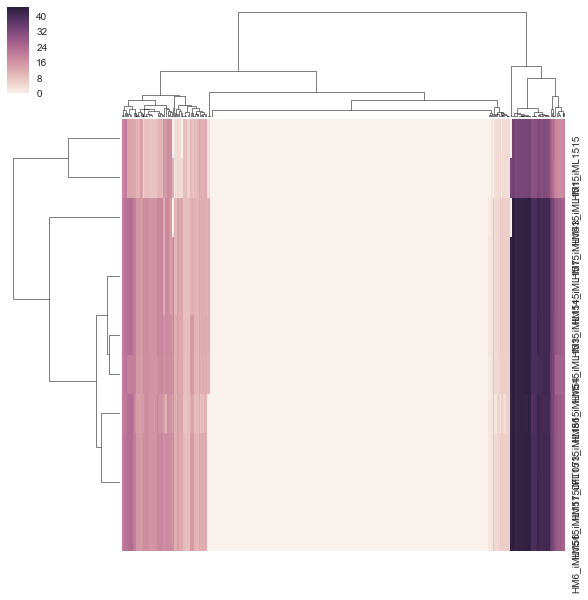

In [107]:
sns.clustermap(df, xticklabels=False)
plt.show()

//anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:136 MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.


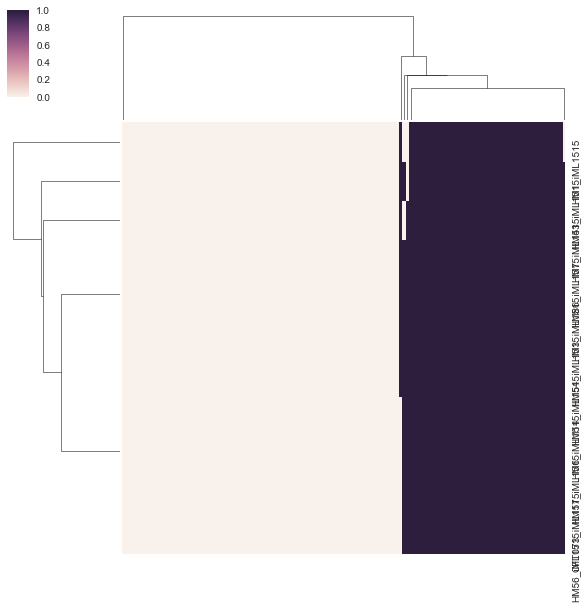

In [53]:
df2 = df.copy()
df2[df2>0] = 1
sns.clustermap(df2, xticklabels=False)
plt.show()

In [9]:
growing = pd.read_csv("../data/2018-04-09_growth_simulations.csv", index_col=0)
growing[growing > 0] = 1
growing['PG'] = ["E", "B1", "B2", "B2", "B1", "B2", "B2", "B1", "B2", "B2", "B2"]
pg = growing.pop("PG")

In [44]:
def visSims(simulation, pg):
   
    num_colors = len(pg.unique())
    colors = [mpl.cm.Set3(1.*i/9) for i in range(1, num_colors +1)]
    lut = dict(zip(pg.unique(), colors))
    row_colors = pg.map(lut)
    strain_cluster = scipy.cluster.hierarchy.linkage(simulation.T)
    cmap = mpl.colors.ListedColormap(["#f7f7f7", "#3b5998"])
     
    g = sns.clustermap(simulation,row_colors=row_colors, cmap=cmap,  cbar_kws={"ticks":[0,1]});
    #g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation = 0, fontsize = 8);
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation = 0, fontsize = 16);

    g.ax_col_dendrogram.set_visible(False)
    legend = [mpl.patches.Patch(color=c, label=l) for l,c in lut.items()]
    l2=g.ax_heatmap.legend(handles=legend, bbox_to_anchor=(-0.25,0.15))
    #l2=g.ax_heatmap.legend(loc='lower left',handles=legend,frameon=True)
    l2.set_title(title='Phylogroup',prop={'size':10})
    #map = mpl.colors.ListedColormap(["#f7f7f7","#3b5998"])
    #g = sns.clustermap(simulation,  col_cluster=False, cmap=cmap);
    
    g.savefig("../data/2018-04-10-growth-simulations.png", dpi=300)
    return g

//anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:136 MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.


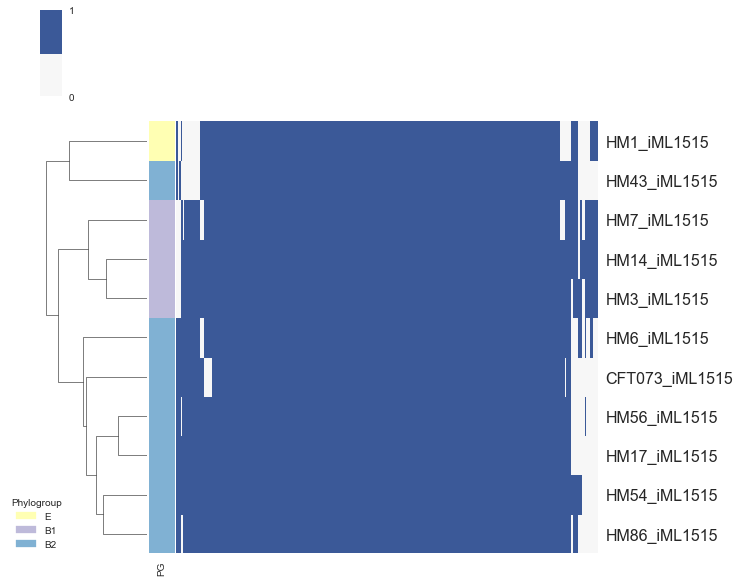

In [25]:
visSims(growing, pg)

In [26]:
diff_growth = growing.loc[:,(growing.sum(axis=0) < 11)]

In [28]:
diff_growth.shape

(11, 91)

//anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:136 MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.


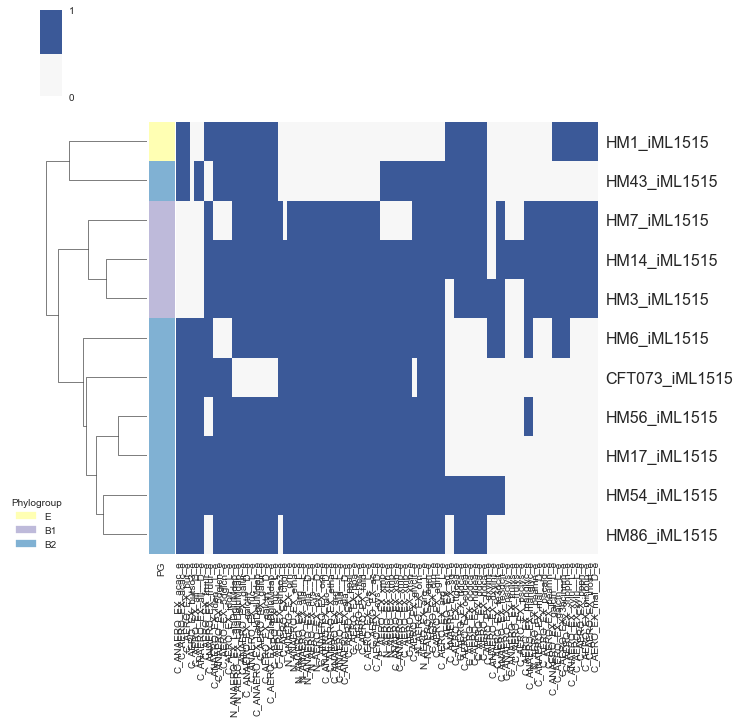

In [45]:
visSims(diff_growth, pg)